<h1 align="center"><b>Shakespeare Style Text Generation</b></h1>
<p align="center">
  <img width="300" height="360" src="https://upload.wikimedia.org/wikipedia/commons/a/a2/Shakespeare.jpg">

<br>
</p>
<p align="center">
Text generation is a language model which is the core of many <b>NLP(Natural Language Processing)</b> task, that automatically generate natural language texts, which can satisfy certain communicative requirements.<br>
This notebook aims at generating text in William Shakespeare's style, using Bi-directional LSTM neural network architecture.
</p>






<h1>Importing necesary libraries</h1>

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

<h1>Load dataset from Kaggle<h1>

>**Dataset:** <a href="https://www.kaggle.com/kingburrito666/shakespeare-plays?select=Shakespeare_data.csv">Shakespeare plays: All of shakespeares plays, characters, lines, and acts in one CSV</a>
<p>The dataset comprised of all of Shakespeare's plays. It contains about 1,11,396 lines from various Act-scenes.</p>

In [2]:
#Upload kaggle API key
from google.colab import files
files.upload()

{}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change permission
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#fetch data from kaggle
!kaggle datasets download -d kingburrito666/shakespeare-plays

shakespeare-plays.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
#unzip the downloaded data 
from zipfile import ZipFile
file_name = "shakespeare-plays.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


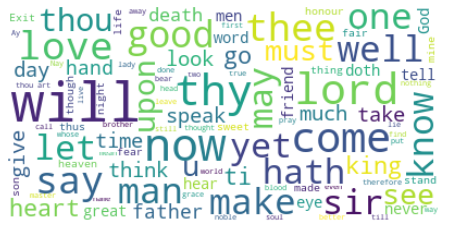

In [6]:
from wordcloud import WordCloud
data = open('/content/alllines.txt').read()
wordcloud = WordCloud(max_font_size=50, max_words=100,
                   background_color="white").generate(data)
plt.rcParams['savefig.dpi'] = 300
plt.figure(figsize = (8,4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("poemcloud.png")
plt.show()

<h1>Data preparation<h1>

In [7]:
#Load csv file
dataset = pd.read_csv('/content/Shakespeare_data.csv')
dataset.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


In [8]:
print("Length of the dataset: ", dataset.shape[0])

Length of the dataset:  111396


**Store all the lines from Shakespeare's plays in a list**

In [9]:
corpus = [] #This list will store all the play lines
text = [lines for lines in dataset.PlayerLine]
for item in text:
  corpus.append(item.lower().strip())

In [10]:
print("Lenght of corpus: ", len(corpus))
print("\nCorpus: ")
corpus[0:10]

Lenght of corpus:  111396

Corpus: 


['act i',
 'scene i. london. the palace.',
 'enter king henry, lord john of lancaster, the earl of westmoreland, sir walter blunt, and others',
 'so shaken as we are, so wan with care,',
 'find we a time for frighted peace to pant,',
 'and breathe short-winded accents of new broils',
 'to be commenced in strands afar remote.',
 'no more the thirsty entrance of this soil',
 "shall daub her lips with her own children's blood,",
 'nor more shall trenching war channel her fields,']

**Tokenize the text** <br>

> <u>tf.keras.preprocessing.text.Tokenizer: -</u><br>
This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary).

In [11]:
tokenizer = Tokenizer()
corpus = corpus[:7000]

#fit tokenize on corpus
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [12]:
print("Input sequence: ", input_sequences.shape)
print("Predictors: ", predictors.shape)
print("Label: ",label.shape)
print("Total words: ",total_words)

Input sequence:  (46036, 34)
Predictors:  (46036, 33)
Label:  (46036, 6528)
Total words:  6528


<h1>Creating Model</h1>
The model designed here for text generation is a sequential model consisiting of <b>Embedding, Bi-direction LSTM, LSTM and a Dense layer. </b><br>

>**Words embedding** is a way to represent words by creating high dimensional vector space in which similar words are close to each other.

> **Bi-dirctional** runs inputs in two ways, one from past to future and one from future to past and what differs this approach from unidirectional is that in the LSTM that runs backward preserves information from the future and using the two hidden states combined you are able in any point in time to preserve information from both past and future.

<p align="center">
  <img width="400" height="150" src="https://miro.medium.com/max/764/1*6QnPUSv_t9BY9Fv8_aLb-Q.png">

<br>
</p>

In [13]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(LSTM(100))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 100)           652800    
_________________________________________________________________
bidirectional (Bidirectional (None, 33, 300)           301200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 6528)              659328    
Total params: 1,773,728
Trainable params: 1,773,728
Non-trainable params: 0
_________________________________________________________________
None


**Model training**

In [14]:
#fit the model on the text corpus
history = model.fit(predictors, label, epochs=200, verbose=1)

Epoch 1/200
1439/1439 [==============================] - 33s 17ms/step - loss: 7.1463 - accuracy: 0.0347
Epoch 2/200
1439/1439 [==============================] - 24s 17ms/step - loss: 6.4623 - accuracy: 0.0544
Epoch 3/200
1439/1439 [==============================] - 24s 17ms/step - loss: 6.1368 - accuracy: 0.0774
Epoch 4/200
1439/1439 [==============================] - 25s 17ms/step - loss: 5.8796 - accuracy: 0.0929
Epoch 5/200
1439/1439 [==============================] - 25s 17ms/step - loss: 5.6762 - accuracy: 0.1025
Epoch 6/200
1439/1439 [==============================] - 25s 17ms/step - loss: 5.4697 - accuracy: 0.1107
Epoch 7/200
1439/1439 [==============================] - 25s 18ms/step - loss: 5.2822 - accuracy: 0.1230
Epoch 8/200
1439/1439 [==============================] - 25s 17ms/step - loss: 5.1011 - accuracy: 0.1269
Epoch 9/200
1439/1439 [==============================] - 25s 17ms/step - loss: 4.9384 - accuracy: 0.1329
Epoch 10/200
1439/1439 [==============================]

**Accuracy and Loss**

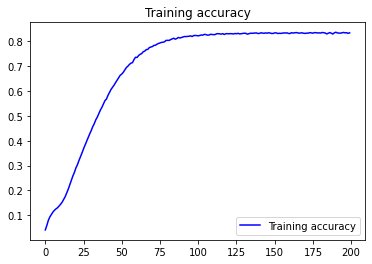

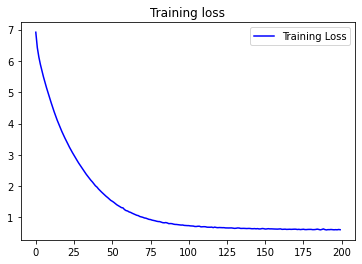

In [20]:
#plot accuracy and loss
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

**Function to generate text**

In [16]:
#function definition
def generate_text(seed_text, next_words, model=model, max_sequence_len=max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text

<h1>Generating Text</h1>

In [27]:
print(generate_text("I wish", 21))

I wish some ravenous wolf had eaten thee o he uncle bow'd a chair and gaolers of england and wind already i am


In [18]:
print(generate_text("This winter", 20))

This winter is the strangest tale that ever i heard poor a question i can conclude that his a field and lead


In [24]:
print(generate_text("My dear Othello",35))

My dear Othello fight picked but all i see you well and even to like thee to my grave my friends and the very good grace of dead talbot come in such a courtesy swain aside to sack


In [28]:
print(generate_text("Death of",20))

Death of him but ye for old other heard the case of all or death too long a silly dwarf reach buckingham


In [29]:
print(generate_text("The prince ",20))

The prince  of wales from such a field as this jest and had it in this reproach be done may have it
